## **1-Import libraries**

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## **2-Load Helper Function**

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-04-13 09:56:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-13 09:56:45 (47.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## **3-Import Functions Using Helper Functions**

In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## **4-Install and Import Split Folders**

In [4]:
pip install split-folders

In [5]:
import splitfolders

## **5-Mount Data From Google Drive**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **6-Load Data from Google Drive**

In [7]:
import zipfile

# unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Deep_Learning_Datasets_For_Practice_Purposes/eye-cancer.zip")
zip_ref.extractall()
zip_ref.close()

## **7-Get Class Names Programmatically**

In [8]:
# get the class names prgrammatically
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/dataset")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # create a list of class_names from the subdirectories
print(class_names)

['.ipynb_checkpoints' 'images']


## **8-Visualize Our Images**

In [9]:
# let's visualize our image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # get a random image path
  random_image = random.sample(os.listdir(target_folder), 1) # this line means randomly sample one item form the target folder
  print(random_image)

  # read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show thw shape of the image

  return img 

## **9-Split The Folders into Train , Validation and Test Datasets**

In [11]:
splitfolders.ratio("/content/dataset/", output="eye_cancer_dataset_model",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 712 files [00:01, 634.52 files/s]


## **10-Set Train, Test and Validation Paths**

In [12]:
train_dir = "/content/eye_cancer_dataset_model/train"
test_dir = '/content/eye_cancer_dataset_model/test/'
val_dir = '/content/eye_cancer_dataset_model/val/'

## **11-Checking Number of Images**

In [14]:
# How many images/classes are there?
walk_through_dir("/content/dataset/images")

There are 0 directories and 712 images in '/content/dataset/images'.


## **12-Set Data Inputs**

In [15]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data =  tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 shuffle=False) # don't shuffle test data for prediction analysis

Found 569 files belonging to 2 classes.
Found 72 files belonging to 2 classes.


## **13-Create Checkpoint Callback**

In [16]:

# Create a checkpoint callback
checkpoint_path = "eye_cancer_classification_model"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

## **14-Make Data Augmentation**

In [17]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomHeight(0.2),
   preprocessing.RandomWidth(0.2),
   preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.)  # rescale inputs of images between 1 & 0, required for models like ResNet50                            
], name= "data_augmentation")



## **15-Setup Base Model (Feature Extraction)**

In [18]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model=tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [19]:
# Get a summary of model we've been created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 2,562
Non-trainable

## **16-Import Metrics**

In [20]:
from tensorflow.keras import metrics

In [21]:
METRICS = [
  metrics.TruePositives(name="tp"),
  metrics.FalsePositives(name="fp"),
  metrics.TrueNegatives(name="tn"),
  metrics.FalseNegatives(name="fn"),
  metrics.CategoricalAccuracy(name="accuracy"),
  metrics.Precision(name="precision"),
  metrics.Recall(name="recall"),
  metrics.AUC(name="auc")
]

## **17-Compile and Fit The Model**

In [22]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)

# Fit
history_for_feature_extraction = model.fit(train_data,
                                           epochs=5, 
                                           validation_data=test_data,
                                           validation_steps=len(test_data))
                                           

Epoch 1/5
18/18 [==============================] - 40s 1s/step - loss: 0.2678 - tp: 503.0000 - fp: 66.0000 - tn: 503.0000 - fn: 66.0000 - accuracy: 0.8840 - precision: 0.8840 - recall: 0.8840 - auc: 0.9632 - val_loss: 0.0128 - val_tp: 72.0000 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 2/5
18/18 [==============================] - 16s 695ms/step - loss: 0.0088 - tp: 569.0000 - fp: 0.0000e+00 - tn: 569.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0032 - val_tp: 72.0000 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/5
18/18 [==============================] - 16s 671ms/step - loss: 0.0039 - tp: 569.0000 - fp: 0.0000e+00 - tn: 569.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.000

## **18-Evaluate The Model**

In [23]:
# Evaluate on the whole test dataset  ##its a feature extraction instead of fine tune
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

3/3 [==============================] - 1s 304ms/step - loss: 0.0016 - tp: 72.0000 - fp: 0.0000e+00 - tn: 72.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000


[0.0015978246228769422, 72.0, 0.0, 72.0, 0.0, 1.0, 1.0, 1.0, 1.0]

## **19-Plot The Graph**

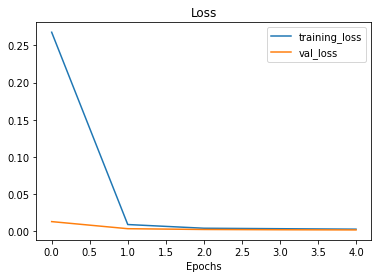

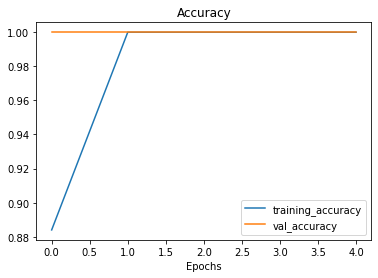

In [24]:
plot_loss_curves(history_for_feature_extraction)

## **20-Unfreeze Some Layers**

In [25]:
base_model.trainable=True

for layer in base_model.layers[:-5]:
  layer.trainable=False

## **21-Recompile and Fit The Model**

In [26]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lower by 10x
              metrics=METRICS)

In [27]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pooling_layer True
output_layer True


In [28]:
# Check which layers in our model is trainable
for layer_number, layer in enumerate(model.layers[1].layers):
  print(layer_number, layer.name, layer.trainable )

0 random_flip True
1 random_rotation True
2 random_height True
3 random_width True
4 random_zoom True


In [29]:
# Fine-tune for more 5 epochs
fine_tune_epochs = 10 # model has already done the 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 =10)

# Fine-tune our model
history_for_fine_tune = model.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=len(test_data),
                                                     initial_epoch=history_for_feature_extraction.epoch[-1])

Epoch 5/10
18/18 [==============================] - 35s 1s/step - loss: 3.5015e-04 - tp: 641.0000 - fp: 0.0000e+00 - tn: 641.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 4.5646e-06 - val_tp: 72.0000 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 6/10
18/18 [==============================] - 16s 639ms/step - loss: 7.0491e-06 - tp: 569.0000 - fp: 0.0000e+00 - tn: 569.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 9.6691e-07 - val_tp: 72.0000 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 7/10
18/18 [==============================] - 15s 617ms/step - loss: 2.3317e-06 - tp: 569.0000 - fp: 0.0000e+00 - tn: 569.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 

## **22-Re_Evaluate The Model**

In [30]:
# Evaluate on the whole test dataset
fine_tune_results =model.evaluate(test_data)
fine_tune_results

3/3 [==============================] - 1s 325ms/step - loss: 5.0498e-07 - tp: 72.0000 - fp: 0.0000e+00 - tn: 72.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000


[5.049810738455562e-07, 72.0, 0.0, 72.0, 0.0, 1.0, 1.0, 1.0, 1.0]

## **23-Compare Histories**

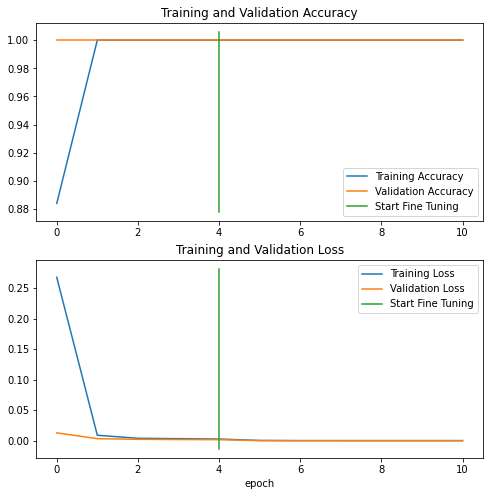

In [31]:
# Compare the historys of feature extraction model with fine-tuning model 
compare_historys(original_history=history_for_feature_extraction,
                 new_history=history_for_fine_tune,
                 initial_epochs=5)

## **24-Save The Model**

In [32]:
# Save our fine-tuning model
model.save("drive/MyDrive/Deep_Learning_Models_h5/eye_cancer_detection_model.h5")

## **25-Load The Model**

In [33]:
# Load and evaluate saved model
loaded_model =tf.keras.models.load_model("drive/MyDrive/Deep_Learning_Models_h5/eye_cancer_detection_model.h5")

In [34]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

3/3 [==============================] - 4s 300ms/step - loss: 5.0498e-07 - tp: 72.0000 - fp: 0.0000e+00 - tn: 72.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000


[5.049810738455562e-07, 72.0, 0.0, 72.0, 0.0, 1.0, 1.0, 1.0, 1.0]

In [35]:
# The results from the saved model (Above) should be very similar to the results below
fine_tune_results

[5.049810738455562e-07, 72.0, 0.0, 72.0, 0.0, 1.0, 1.0, 1.0, 1.0]

## **26-Make Prediction Probabilites**

In [36]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it left

3/3 [==============================] - 3s 347ms/step


In [37]:
len(test_data)

3

In [38]:
# How many predictions are there?
len(preds_probs)

72

In [39]:
# What's the shape of our predictions?
preds_probs.shape

(72, 2)

In [40]:
# Let's see whats the first 10 predictions looks like
preds_probs[:10]

array([[5.7150022e-09, 1.0000000e+00],
       [1.8593428e-07, 9.9999976e-01],
       [3.7277658e-07, 9.9999964e-01],
       [2.7433666e-07, 9.9999976e-01],
       [2.8291108e-08, 1.0000000e+00],
       [5.1739800e-08, 1.0000000e+00],
       [1.5792896e-06, 9.9999845e-01],
       [6.4259439e-08, 9.9999988e-01],
       [2.0156949e-07, 9.9999976e-01],
       [5.8998609e-07, 9.9999940e-01]], dtype=float32)

In [41]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.7150022e-09, 1.0000000e+00], dtype=float32), 2, 1.0000000057150022)

In [42]:
# We get one prediction probability per class(in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilites for sample 0: {len(preds_probs[0])}")
print(f"What prediction probabilites sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")


Number of prediction probabilites for sample 0: 2
What prediction probabilites sample 0 looks like:
 [5.7150022e-09 1.0000000e+00]
The class with highest predicted probability by the model for sample 0: 1


In [43]:
# Get the pred classes of each model
pred_classes = preds_probs.argmax(axis=1)

# How do they look like?
pred_classes[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [44]:
# How many pred classes we have?
len(pred_classes)

72

In [45]:
# To get our test dataset labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1,.....0,0], we want the index value where the index value "1" occurs
y_labels[:10] # look at the first 10 

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [46]:
# How many y_labels are there?
len(y_labels)

72

In [47]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [48]:
len(test_data)

3

## **27-Make Confusion Matrix**

In [49]:
from helper_functions import make_confusion_matrix

In [50]:
# Get a list of class names
class_names =test_data.class_names
class_names[:10]

['.ipynb_checkpoints', 'images']

In [51]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-label print verticaly
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### changes (x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

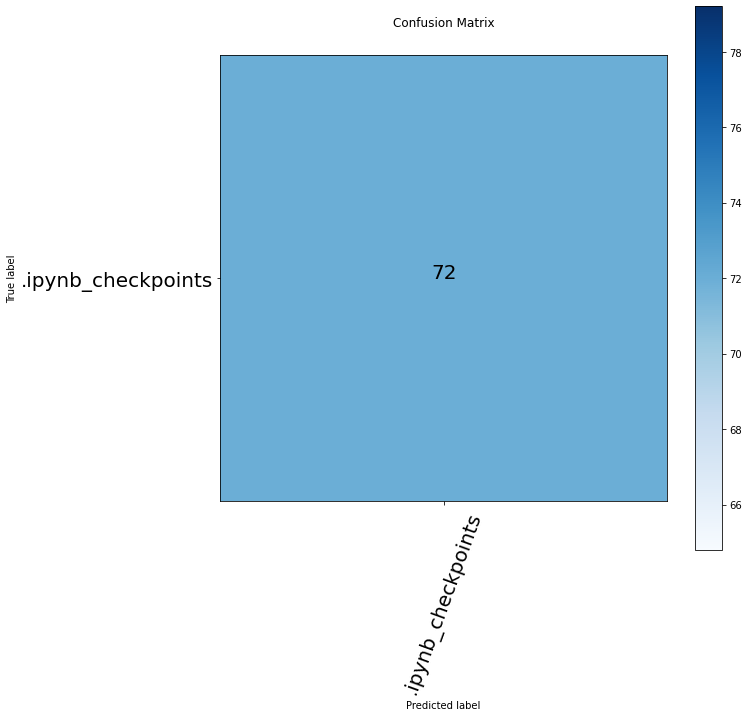

In [52]:
make_confusion_matrix(y_true=y_labels,
                       y_pred=pred_classes,
                       classes=class_names,
                      figsize=(10, 10),
                      text_size=20,
                      savefig=True)

## **28-Make Classification Report**

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        72

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



In [54]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'1': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 72},
 'accuracy': 1.0,
 'macro avg': {'f1-score': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'support': 72},
 'weighted avg': {'f1-score': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'support': 72}}

In [56]:
class_names[1]

'images'

In [58]:
classification_report_dict["1"]["f1-score"]

1.0

In [59]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
     # Add names and f1-scores to new dictionary
     class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores     


{'images': 1.0}

In [60]:
# Turn f1 scores into Dataframe visualization
import pandas as pd
f1_scores =pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                        "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores                

,class_names,f1-score
0,images,1.0


In [61]:
f1_scores[:2]

,class_names,f1-score
0,images,1.0


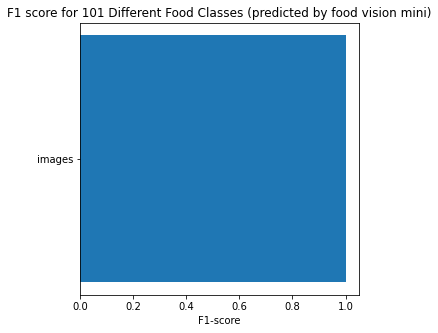

In [62]:
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score value
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1 score for 101 Different Food Classes (predicted by food vision mini)")
ax.invert_yaxis(); # reverse the order of our plot


# Challenge: add value to the end of each bar of what the actual f1-score is 
# (hint: use the "autolabel" function from here: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html) 

## **29-Load and Prepare Images Function**

In [63]:
# Create a function to load and create a images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Read in an image from filename, turn it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename(str): path to target image
    image_shape(int): height/width dimension of target image size
    scale(bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3) 

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale Yes/no?
  if scale:
    # reshape the image (get all value between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale image for EffiecienNet model in TensorFlow   


In [69]:
# # Make preds on series of images
# import os
# import random

# plt.figure(figsize=(27,20))
# for i in range(3):
#   # Choose a random image(s) from a random class(es)
#   class_name =random.choice(class_names)
#   filename = random.choice(os.listdir(val_dir + "/" + class_name))
#   filepath = val_dir + class_name + "/" + filename


#   # Load the image and make predictions
#   img = load_and_prep_image(filepath, scale=False)
#   # print(img.shape)
#   img_expanded = tf.expand_dims(img, axis=0)
#   # print(img_expanded.shape)
#   pred_prob = model.predict(img_expanded) # get prediction probability array
#   pred_class = class_names[pred_prob.argmax()] # get heighst prediction probability index and match it class_names list
#   # print(pred_prob)
#    # print(pred_class)

#     # Plot the image(s)
#   plt.subplot(1, 3, i+1)
#   plt.imshow(img/255.)
#   if class_name == pred_class: # if predicted class matches truth class, make text green
#     title_color = "g"
#   else:
#     title_color ="r"
#   plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.argmax():.2f}", c=title_color)
#   plt.axis(False);  